# Run Data Assimilation 

In this notebook, we run the core data assimilation (DA) procedure to reconstruct past climate states, following the Last Millennium Reanalysis (LMR) framework as implemented in [Tardif et al. 2019](https://cp.copernicus.org/articles/15/1251/2019/). We use the [`cfr`](https://fzhu2e.github.io/cfr/ug-api.html) package with no edits to reproduce LMRv2.1, a benchmark paleoclimate reanalysis product.

**WARNING**: This notebook is designed to run on USC's Center for Advanced Research Computing (CARC) HPC cluster due to the computational resources required for this data assimilation workflow.


### shell file for CARC

This shell is used via  `sbatch`

```bash
#!/bin/bash

#SBATCH --partition=main
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=32G
#SBATCH --time=40:00:00

module purge
eval "$(conda shell.bash hook)"

conda activate cfr-env

python lmr_reproduce.py
```


In [1]:
%load_ext autoreload
%autoreload 2

import cfr
import numpy as np
print(cfr.__version__)

octave not found, please see README
2025.5.7


## Load Data
The data needed to run this reconstruction comes in three parts:
- Prior: Model output climate data (CMIP5 CCSM4)
- Calibration: Instrumental climate data (temperature: GISTEMPv4, precipitation: GPCCv6)
- Proxy: Proxy data (from PAGES2k)

1. Download from [here](http://www.atmos.uw.edu/~wperkins/nobackup/lmr_data/LMR_data.tar.gz)
2. Extract all relevant contents into ./prev_data/
3. **Prior** data can be found under LMR_data > data > model > ccsm4_last_millenium\
    a. Put in directory ./prev_data/ccsm4_last_millenium/ \
    b. Required:
    - pr_sfc_Amon_CCSM4_past1000_085001-185012.nc
    - tas_sfc_Amon_CCSM4_past1000_085001-185012.nc
6. **Calibration** data can be found under LMR_data > data > analyses copy > GPCC
    - The other calibration dataset (GISTEMPv4) comes shipped with _cfr_, but GPCCv6 does not. 
7. **Proxy** data ([PAGES2kv2](https://pastglobalchanges.org/science/wg/2k-network/Phase_2_Databases/Global_Temp/V2.0.0_2017)) will come from any variant of Step 1. 

> Note: As mentioned, the correct version of GISTEMP is bundled within _cfr_, but the correct version of GPCC needs to be downloaded and put into the prev_data folder for ease of flow. 

### Load proxies

The preparation of these records is described in detail in ~Notebook C01~, where the data is accessed through either a pickle file or the LipDGraph and processed to fit the format of _cfr_'s ```ProxyDatabase``` Class.\
\
```load_proxydb()``` takes in a .json, .pckl, or .nc file and with the given columns, very specific to _cfr_, creates a new ```ProxyDatabase``` object for our use in the reconstruction. In this specific example, we will use a NetCDF file created by Step 1. 

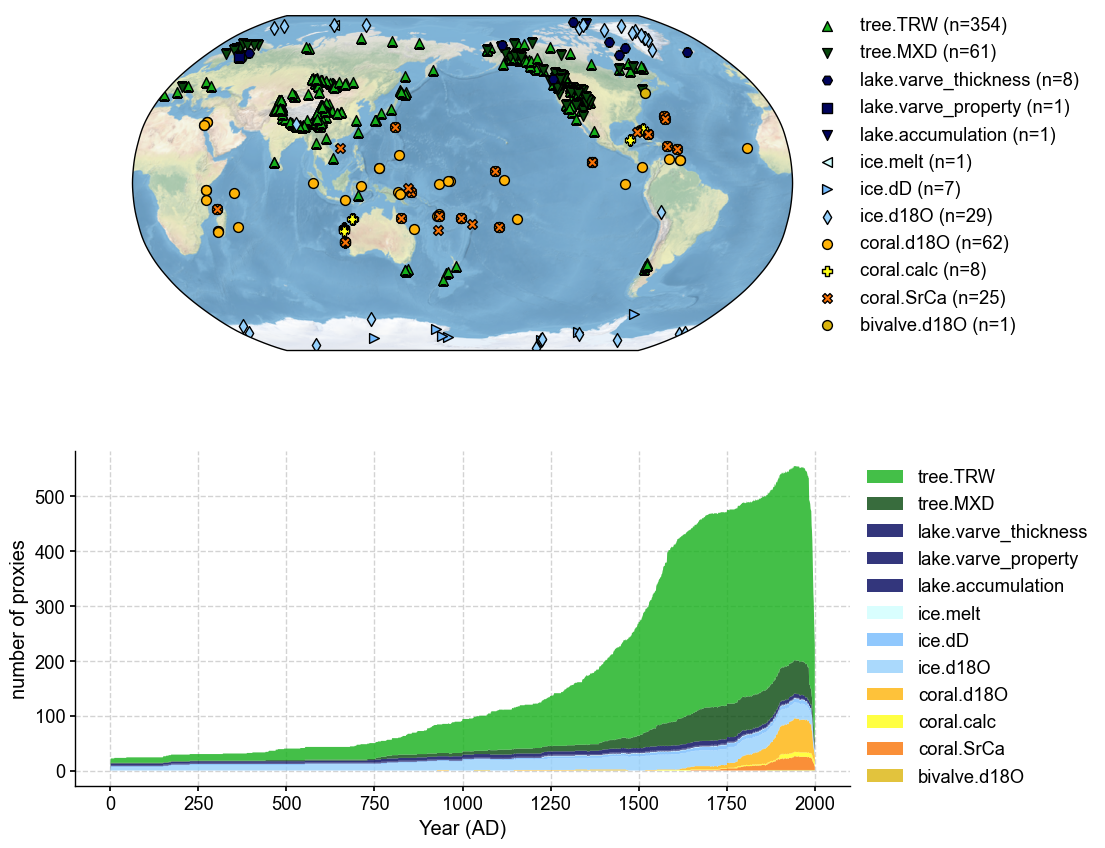

In [2]:
# will change based on which netcdf we use

pdb = cfr.ProxyDatabase().load_nc('./prev_data/filtered_ptype_res_cfr_pages2kv2.nc')
pdb.refresh()

job = cfr.ReconJob()
job.proxydb = pdb

fig, ax = job.proxydb.plot(plot_count=True)

### Load model prior 

This reconstruction uses [CMIP5 CCSM4 past 1000](https://www.wdc-climate.de/WDCC/CMIP5/Compact.jsp?acronym=NRS4pk) as the model prior. This is the Coupled Model Intercomparison Project phase 5 (CMIP5) (Taylor et al., 2012) Last Millennium simulation from the Community Climate System Model version 4 (CCSM4) coupled atmosphere–ocean–sea-ice model. The simulation covers years 850 to 1850 CE and includes incoming solar variability and variable greenhouse gases, as well as stratospheric aerosols from volcanic eruptions known to have occurred during the simulation period (Tardif et al., 2019). This model prior provides the initial climate states used in the data assimilation (DA) step.\
\
```load_clim()``` loads in .nc files (or files that are shipped with the package) and formats them into ```ClimateField``` objects for use in the DA workflow.\
\
```anom_period``` refers to the climatological reference period with which to compute climate anomalies. Tardif et al. use the full interval for LMRv2.1. Defining this is essential to maintaining a consistent anomaly calculation throughout the reconstruction.

In [3]:
job.load_clim(
    tag='prior',
    
    path_dict= {
    'tas': './prev_data/ccsm4_last_millenium/tas_sfc_Amon_CCSM4_past1000_085001-185012.nc',
    'pr': './prev_data/ccsm4_last_millenium/pr_sfc_Amon_CCSM4_past1000_085001-185012.nc'
    },
    anom_period=[850,1850],  # Tardif 2019 uses entire interval
    load=True,  
    verbose=True,
)

>>> job.configs["prior_path"] = {'tas': './prev_data/ccsm4_last_millenium/tas_sfc_Amon_CCSM4_past1000_085001-185012.nc', 'pr': './prev_data/ccsm4_last_millenium/pr_sfc_Amon_CCSM4_past1000_085001-185012.nc'}
>>> job.configs["prior_anom_period"] = [850, 1850]
>>> job.configs["prior_lat_name"] = lat
>>> job.configs["prior_lon_name"] = lon
>>> job.configs["prior_time_name"] = time
>>> The time axis does not overlap with the reference period [850, 1850]; use its own time period as reference [.2f, .2f].
>>> The time axis does not overlap with the reference period [850, 1850]; use its own time period as reference [.2f, .2f].
>>> prior variables ['tas', 'pr'] loaded
>>> job.prior created


Do a check in after loading to make sure the NetCDF file loaded in correctly. If there are any ```NaN``` values, you will be warned.

In [4]:
# Check after load
print("\nAfter initial load:")
print("Shape:", job.prior['tas'].da.shape)
print("Contains NaN?", np.any(np.isnan(job.prior['tas'].da.values)))
if not np.any(np.isnan(job.prior['tas'].da.values)):
    print("Sample values from first timestep:")
    vals = job.prior['tas'].da.isel(time=0, lat=slice(0,5), lon=slice(0,5)).values
    print(vals)


After initial load:
Shape: (12012, 192, 288)
Contains NaN? False
Sample values from first timestep:
[[ 4.2724609e-04 -1.4116669e+00 -1.4149780e+00 -7.6078796e-01
  -1.3295441e+00]
 [ 2.8004456e-01  2.4789429e-01  3.3767700e-01 -5.2047729e-02
   3.3233643e-01]
 [ 4.6669006e-01 -1.6618347e-01  5.8181763e-01 -2.5801086e-01
   2.7944946e-01]
 [ 3.3268738e-01  3.2659912e-01  3.8771057e-01  4.2834473e-01
   6.8528748e-01]
 [ 3.4626770e-01  3.5942078e-01  6.5942383e-01  1.0366669e+00
   7.7363586e-01]]


### Load calibration data

The calibration data sets used in this study are the NASA Goddard Institute for Space Studies (GISS) Surface Temperature Analysis ([GISTEMP](https://data.giss.nasa.gov/gistemp/news/2010summer/)) (Hansen et al., 2010) version 4 for temperature and the gridded precipitation data set from the Global Precipitation Climatology Centre ([GPCC](https://psl.noaa.gov/data/gridded/data.gpcc.html)) (Schneider et al., 2014) version 6 as the source of monthly information on moisture input over land surfaces (Tardif et al., 2019).\
\
```anom_period``` is restricted exclusively to the instrumental period due to observational data constraints. 

In [5]:
job.load_clim(
    tag='obs',
    path_dict={
        'pr': './prev_data/GPCC_precip.mon.flux.1x1.v6.nc',
        'tas': 'gistemp1200_ERSSTv4'
    },
    rename_dict={'pr': 'precip','tas': 'tempanomaly'},
    anom_period=[1951, 1980], 
    load=True,
    verbose = True
)

>>> job.configs["obs_path"] = {'pr': './prev_data/GPCC_precip.mon.flux.1x1.v6.nc', 'tas': 'gistemp1200_ERSSTv4'}
>>> job.configs["obs_rename_dict"] = {'pr': 'precip', 'tas': 'tempanomaly'}
>>> job.configs["obs_anom_period"] = [1951, 1980]
>>> job.configs["obs_lat_name"] = lat
>>> job.configs["obs_lon_name"] = lon
>>> job.configs["obs_time_name"] = time
>>> The target file seems existed at: ./data/gistemp1200_ERSSTv4.nc.gz . Loading from it instead of downloading ...
>>> obs variables ['pr', 'tas'] loaded
>>> job.obs created


## Calibrate PSMs

PSM Calibration is a crucial step in the DA process because it defines a quantitative relationship between our observational data and the climate. Since proxies don't directly record climate variables (e.g.,temperature, precipitation), PSM calibration translates the climate variable from instrumental measurements into proxy variables (e.g., d18O, Mg/Ca). This makes sure that the proxy information is on the same scale as the prior climate state, allowing the DA algorithm to correctly weight and blend proxy data with model output. Without proper calibration, we risk introducing biases or inconsistencies between proxies and the prior, which can add error to the reconstruction. \
\
The first step is to create a dictionary between the proxy archive type and the type of calibration equation used. For most in LMRv2.1, they are linear univariate, with the exception being Tree Ring Width (TRW) which is bilinear, with temperature and precipitation used as inputs.

\
Next we specify a dictionary for seasonal growth. This defines the optimal growth periods in which the proxy archive experiences the fastest or most efficient growth in a caledar year. All possible growth seasons are checked and the optimal one is selected during the calibration step to maximize correlation with the climate variable. 



In [6]:
# PSM to be used
ptype_psm_dict = {
    'tree.TRW': 'Bilinear',
    'tree.MXD': 'Linear',
    'coral.d18O': 'Linear',
    'coral.SrCa': 'Linear',
    'ice.d18O': 'Linear',
    'ice.dD': 'Linear',
    'lake.varve_thickness': 'Linear',
}

# target variables
ptype_clim_dict = {
    'tree.TRW': ['tas', 'pr'],
    'tree.MXD': ['tas'],
    'coral.d18O': ['tas'],
    'coral.SrCa': ['tas'],
    'ice.d18O': ['tas'],
    'ice.dD': ['tas'],
    'lake.varve_thickness': ['tas'],
}

# Seasonality for each proxy type
ptype_season_dict = {
    'tree.TRW': [  # expert curated pool of possible growing seasons
        [1,2,3,4,5,6,7,8,9,10,11,12],
        [6,7,8],
        [3,4,5,6,7,8],
        [6,7,8,9,10,11],
        [-12,1,2],
        [-9,-10,-11,-12,1,2],
        [-12,1,2,3,4,5],
    ],
    'tree.MXD': [  # expert curated pool of possible growing seasons
        [1,2,3,4,5,6,7,8,9,10,11,12],
        [6,7,8],
        [3,4,5,6,7,8],
        [6,7,8,9,10,11],
        [-12,1,2],
        [-9,-10,-11,-12,1,2],
        [-12,1,2,3,4,5],
    ],
    'coral.d18O': list(range(1, 13)),            # annual
    'coral.SrCa': list(range(1, 13)),            # annual
    'ice.d18O': list(range(1, 13)),              # annual
    'ice.dD': list(range(1,13)),
    'lake.varve_thickness': list(range(1, 13)),  # annual
}

```annualize_proxydb``` annualizes the subannual records. 

In [7]:
job.annualize_proxydb(months=list(range(1, 13)), verbose=True)

>>> job.configs["annualize_proxydb_months"] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
>>> job.configs["annualize_proxydb_ptypes"] = {'lake.accumulation', 'bivalve.d18O', 'coral.d18O', 'ice.dD', 'tree.MXD', 'coral.calc', 'ice.d18O', 'tree.TRW', 'ice.melt', 'lake.varve_thickness', 'coral.SrCa', 'lake.varve_property'}


Annualizing ProxyDatabase: 100%|██████████| 558/558 [01:08<00:00,  8.09it/s]

>>> 558 records remaining
>>> job.proxydb updated


`calib_psms` does what was described above. It takes in the observational proxy data and calibrates it using instrumental climate data to get a best fit regression. The `nobs_lb=25` parameter classifies the overlap between the proxy data and calibration data. It requires there by at least 25 years of overlap between the two, but is an adjustable parameter. We use 25 because that is what was done in LMRv2.1. This ensures that the statistical calibration is based on a long enough overlap to be robust.

In [8]:
job.calib_psms(
    ptype_psm_dict=ptype_psm_dict,
    ptype_season_dict=ptype_season_dict,
    ptype_clim_dict=ptype_clim_dict,
    nobs_lb = 25,
    verbose=True,
)

>>> job.configs["ptype_psm_dict"] = {'lake.accumulation': 'Linear', 'bivalve.d18O': 'Linear', 'coral.d18O': 'Linear', 'ice.dD': 'Linear', 'coral.calc': 'Linear', 'tree.MXD': 'Linear', 'ice.d18O': 'Linear', 'tree.TRW': 'Bilinear', 'ice.melt': 'Linear', 'lake.varve_thickness': 'Linear', 'coral.SrCa': 'Linear', 'lake.varve_property': 'Linear'}
>>> job.configs["ptype_season_dict"] = {'lake.accumulation': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'bivalve.d18O': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'coral.d18O': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'ice.dD': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'coral.calc': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'tree.MXD': [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], [6, 7, 8], [3, 4, 5, 6, 7, 8], [6, 7, 8, 9, 10, 11], [-12, 1, 2], [-9, -10, -11, -12, 1, 2], [-12, 1, 2, 3, 4, 5]], 'ice.d18O': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'tree.TRW': [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], [6, 7, 8], [3, 4, 5, 6, 7, 8], [6, 7, 8, 9, 10, 11], [-12, 1

Calibrating the PSMs:   9%|▉         | 53/558 [01:06<07:32,  1.12it/s]

Asi_117 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_117 >>> Found nearest climate within distance of 1 deg.


Calibrating the PSMs:  29%|██▉       | 162/558 [03:04<06:34,  1.00it/s]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  48%|████▊     | 268/558 [04:52<03:16,  1.47it/s]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  60%|█████▉    | 333/558 [06:06<02:39,  1.41it/s]

Asi_111 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_111 >>> Found nearest climate within distance of 1 deg.


Calibrating the PSMs:  87%|████████▋ | 488/558 [09:04<00:49,  1.40it/s]

Asi_118 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_118 >>> Found nearest climate within distance of 1 deg.


Calibrating the PSMs:  98%|█████████▊| 549/558 [10:15<00:10,  1.14s/it]

Asi_119 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_119 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_119 >>> Found nearest climate within distance of 2 deg.


Calibrating the PSMs: 100%|██████████| 558/558 [10:25<00:00,  1.12s/it]

The number of overlapped data points is 0 < 25. Skipping ...
>>> PSM for Arc_026 failed to be calibrated.
>>> PSM for Ocn_138 failed to be calibrated.
>>> PSM for Arc_014 failed to be calibrated.
>>> 555 records tagged "calibrated" with ProxyRecord.psm created


### Run PSMs

```forward_psms``` runs the forward model (the PSM) with the prior as inputs and returns model-derived pseudoproxies as an output to be used in the DA solver. 

In [9]:
job.forward_psms(verbose=True)

>>> job.configs["ptype_forward_dict"] = {}


Forwarding the PSMs: 100%|██████████| 555/555 [02:41<00:00,  3.44it/s]

>>> ProxyRecord.pseudo created for 555 records


### Annualize and Regrid model prior fields

Annualization ensures consistency between prior and proxy time values. This ensures that there is no subannual data in the prior set.

Regridding is a way to reduce dimensionality / match assimilation settings.

In [10]:

job.annualize_clim(tag='prior', verbose=True, months=list(range(1, 13)))
job.regrid_clim(tag='prior', nlat=42, nlon=63, verbose=True)

>>> job.configs["prior_annualize_months"] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
>>> Processing tas ...
>>> Processing pr ...
>>> job.prior updated
>>> job.configs["prior_regrid_nlat"] = 42
>>> job.configs["prior_regrid_nlon"] = 63
>>> Processing tas ...
>>> Processing pr ...


### (Optional) Save the job object for later reload

In [11]:
# path name can change

job.save('./cases/lmr_reproduce_pda', verbose=True)

>>> job.configs["save_dirpath"] = ./cases/lmr_reproduce_pda
>>> prior_tas saved to: ./cases/lmr_reproduce_pda/prior_tas.nc
>>> prior_pr saved to: ./cases/lmr_reproduce_pda/prior_pr.nc
>>> obs_pr saved to: ./cases/lmr_reproduce_pda/obs_pr.nc
>>> obs_tas saved to: ./cases/lmr_reproduce_pda/obs_tas.nc
>>> job saved to: ./cases/lmr_reproduce_pda/job.pkl


## Run DA solver

The DA solver used in LMRv2.1 (and _cfr_) is the Kalman Filter. In simple terms, the Kalman filter uses the innovation (difference between observed proxy data and forward model-derived pseudoproxy values) to adjust the model's estimate.  The amount of adjustment depends on the relative uncertainties in the proxies and the model. The Kalman filter gives more weight to whichever source (proxy or climate) has a smaller error, resulting in an updated estimate of the climate state at each time step.  \
\
We run 51 Monte Carlo (MC) iterations with 100 ensemble members each. This gives us 5100 realizations of past climate states. These 5100 ensemble members helps characterize uncertainty. 

In [12]:
job.run_da_mc(
    save_dirpath='./recons/lmr_reproduce_pda',
    recon_seeds=list(range(1, 2)),  # 1 iteration is an example, it will be 51 on CARC
    recon_vars=['tas','pr'],  # the climate variables we are reconstructing
    recon_period=[1, 2000], # the reconstruction time period 
    verbose=True,
)

>>> job.configs["recon_period"] = [1, 2000]
>>> job.configs["recon_loc_rad"] = 25000
>>> job.configs["recon_timescale"] = 1
>>> job.configs["recon_vars"] = ['tas', 'pr']
>>> job.configs["nens"] = 100
>>> job.configs["recon_seeds"] = [1]
>>> job.configs["assim_frac"] = 0.75
>>> job.configs["save_dirpath"] = ./recons/lmr_reproduce_pda
>>> job.configs["compress_params"] = {'zlib': True}
>>> job.configs["output_full_ens"] = False
>>> job.configs["recon_sampling_mode"] = fixed
>>> job.configs["trim_prior"] = True
>>> job.configs["allownan"] = False
>>> seed: 1 | max: 1


KF updating: 100%|██████████| 2000/2000 [20:54<00:00,  1.59it/s]


>>> Reconstructed fields saved to: ./recons/lmr_reproduce_pda/job_r01_recon.nc
>>> DONE! Total time spent: 23.10 mins.


## Figure checks

After running the full DA workflow, we want to make sure the reconstructions actually exist, so let's do a quick check to confirm that we get both a climate field and an ensemble time series for the ```'tas'``` and ```'pr'``` variables.

In [13]:
res = cfr.ReconRes('./recons/lmr_reproduce_pda/')

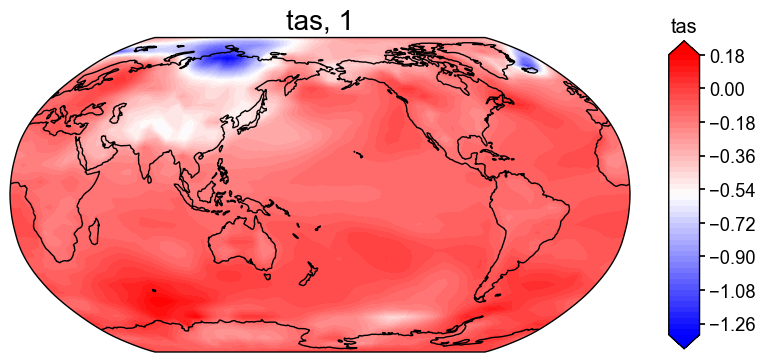

In [14]:
res.load(['tas', 'tas_gm', 'pr', 'pr_gm'])

# Create a basic plot
if 'tas' in res.recons:
    fig, ax = res.recons['tas'].plot(cmap='bwr')

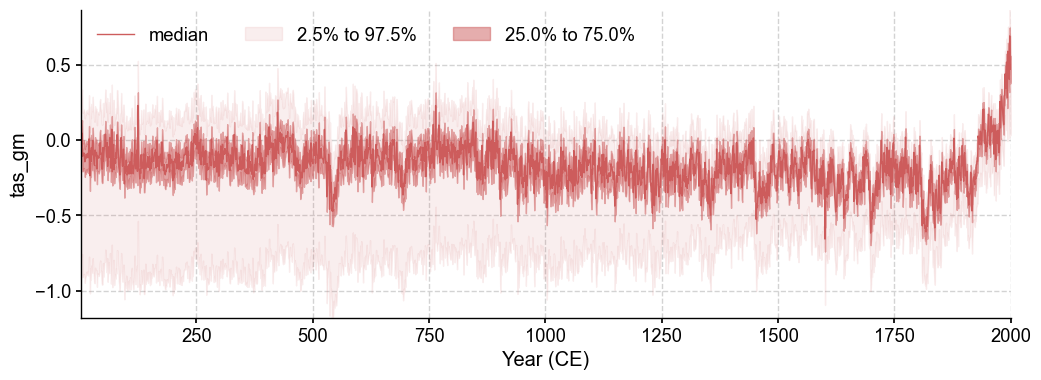

In [15]:
# Plot with ensemble spread
fig, ax = res.recons['tas_gm'].plot_qs()

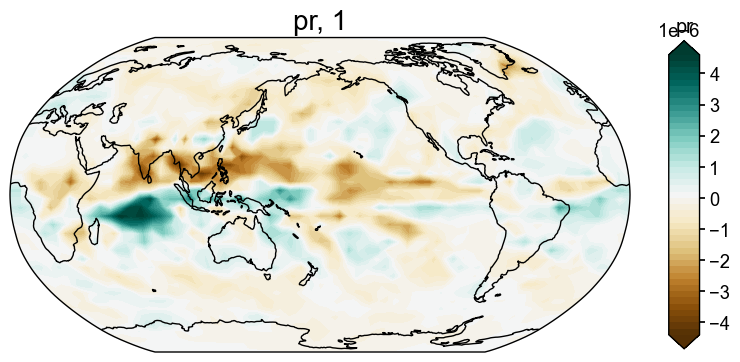

In [16]:
fig, ax = res.recons['pr'].plot()

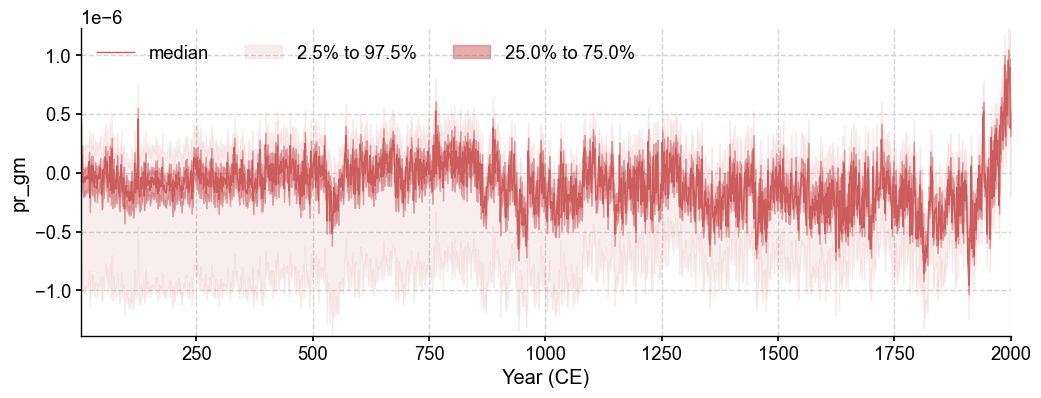

In [17]:
fig, ax = res.recons['pr_gm'].plot_qs()

Looks like it works!